# Preliminary Investigation of Data

1. Descriptive Statistics
2. Data Preparation
    - Stationarization
    - Intraday volatility adjustment
    - Normalization
    - TSI
3. Stock/TSI Correlation


In [1]:
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
	!pip install seaborn
	!pip install statsmodels
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from scipy import stats
import matplotlib.pyplot as plt
from data.jpx import *

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
# register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdatesl

TSE33 = TOPIX_SECTORS()
NKY = Nikkei225()
inst = NKY.get_ric("6758.T")
print(f"inst: {inst}")
s = Stock(inst, TSE33)

## 1. Descriptive Statistics
### Initial Data
The initial data from the supplier has had 0 price changes added in where missing from stock prices and interpolated prices where missing for TSI indices. Also the daily open and close prices are removed as they need to be modelled as a separate process.

In [21]:
%%capture --no-stdout
df_raw_data = s.df_intraday.drop(columns=['COUNT', 'VOLUME', 'RETURN', 'RETURN_ADJ', 'CLOSE_TPX', 'RETURN_TPX', 'RETURN_ADJ_TPX', 'RETURN_NORM', 'RETURN_NORM_TPX'])
print(df_raw_data.describe())
print("\r\nThe kurtosis of any univariate normal distribution is 3.")
print("Distributions with kurtosis less than 3 are called platykurtic, the distribution produces fewer and less extreme outliers than does the normal distribution.")
print("Distributions with kurtosis greater than 3 are called leptokurtic, the distribution produces more outliers than the normal distribution.")
print("The prices have low kurtosis because of autocorrelation.")
print(f"\r\nKurtosis:\r\n{df_raw_data.kurtosis().to_frame().T}\r\n")
data = s.df_intraday['RETURN']

               HIGH           LOW          OPEN         CLOSE
count  73105.000000  73105.000000  73105.000000  73105.000000
mean   11389.703057  11379.947199  11384.876602  11384.846974
std     1064.566320   1063.859893   1064.205256   1064.195629
min     9405.000000   9388.000000   9399.000000   9398.000000
25%    10645.000000  10635.000000  10640.000000  10640.000000
50%    11250.000000  11240.000000  11245.000000  11245.000000
75%    11995.000000  11985.000000  11990.000000  11990.000000
max    14510.000000  14460.000000  14505.000000  14475.000000

The kurtosis of any univariate normal distribution is 3.
Distributions with kurtosis less than 3 are called platykurtic, the distribution produces fewer and less extreme outliers than does the normal distribution.
Distributions with kurtosis greater than 3 are called leptokurtic, the distribution produces more outliers than the normal distribution.
The prices have low kurtosis because of autocorrelation.

Kurtosis:
       HIGH       LOW 

#### Autocorrelation in CLOSE series

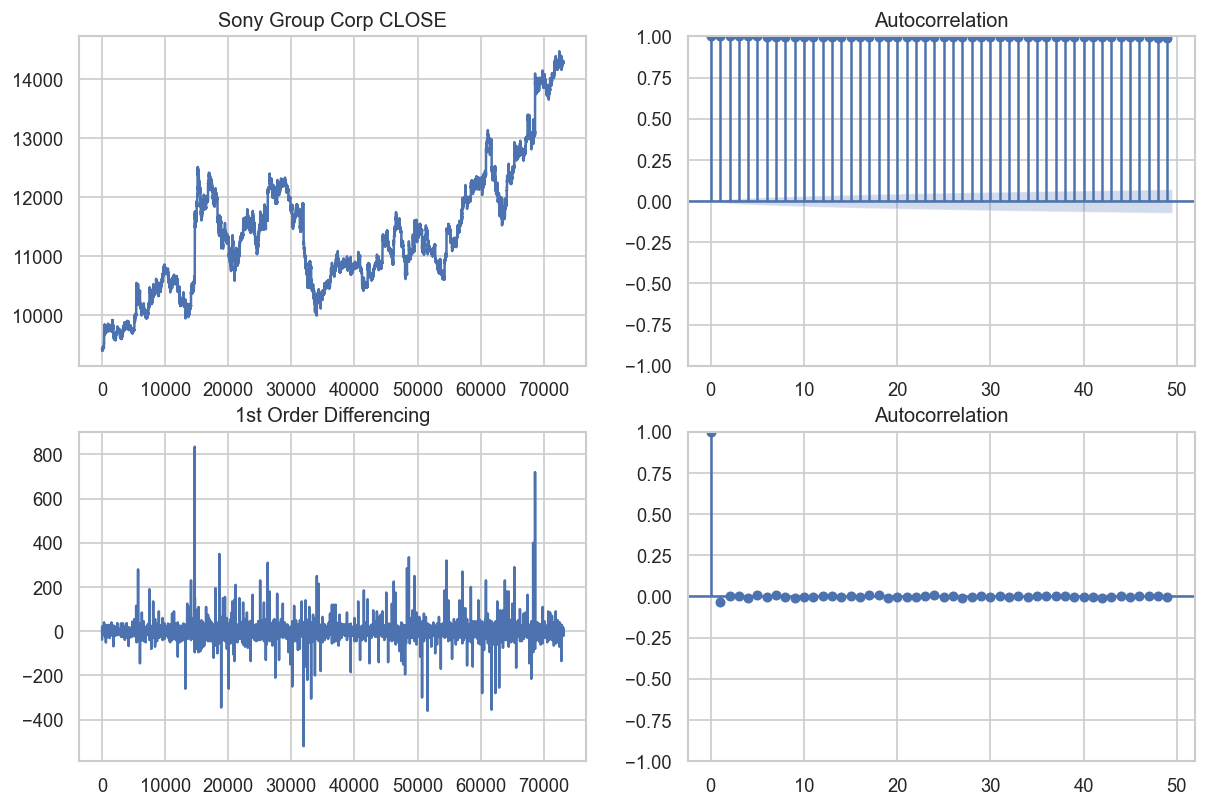

In [22]:
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':120})

close = s.df_intraday['CLOSE'].dropna()
df = close
#df = s.df_the_date[['CLOSE', 'Date']].dropna()

# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(df); axes[0, 0].set_title(f"{inst[2]} CLOSE")
# axes[0,1].set_xlim([0, 100])
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[1, 1])

plt.show()

In [29]:
result = adfuller(close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
result = adfuller(close.diff().dropna())
print('1st Order Differenced ADF Statistic: %f' % result[0])
print('1st Order Differenced p-value: %f' % result[1])

ADF Statistic: -0.962157
p-value: 0.766815
1st Order Differenced ADF Statistic: -101.380268
1st Order Differenced p-value: 0.000000


## 2. Data Preparation
### Stationarization
The return from the stock in percentage terms is simply the difference in value between the two periods divided by the beginning value. 

$$R_t = \frac{C_t - C_{t-1}}{C_t}$$
where $R_t$ is Return at time t, $C_t$ is Closing Price at time t.

Return is the first order of differencing of the CLOSE series to make the time series stationary, additionally divided by the previous time to make it a percentage. 

                 Date   CLOSE    RETURN
0 2020-11-24 00:06:00  9440.0 -0.000635
1 2020-11-24 00:07:00  9402.0 -0.004025
2 2020-11-24 00:08:00  9409.0  0.000745
3 2020-11-24 00:09:00  9429.0  0.002126
4 2020-11-24 00:10:00  9436.0  0.000742


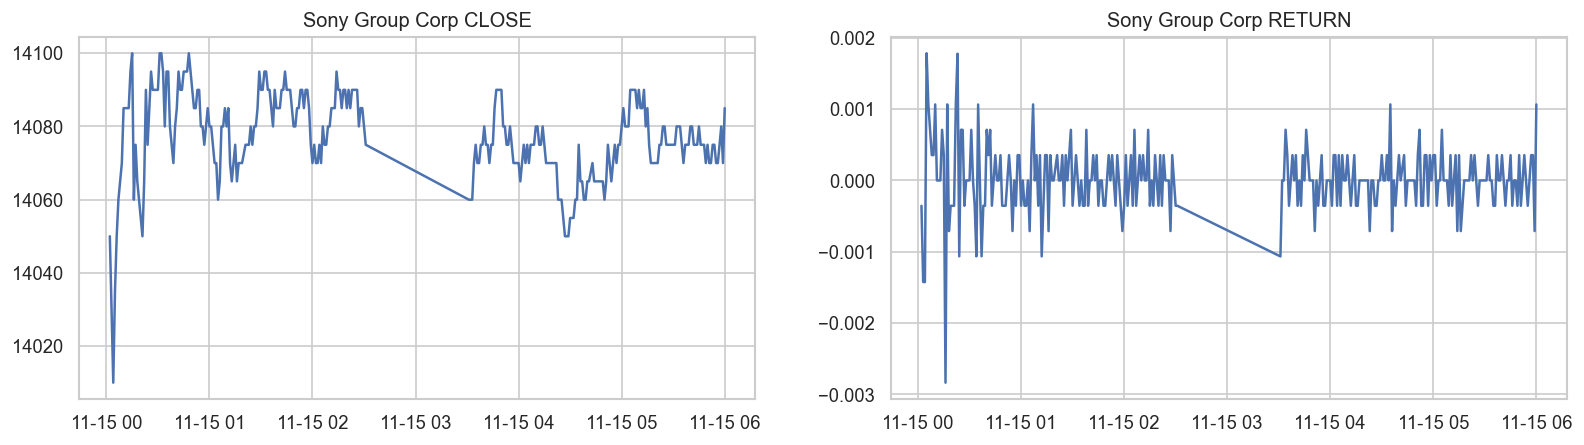

In [24]:
print(s.df_intraday[['Date', 'CLOSE', 'RETURN']].head())
data_1day = s.window('2021-11-15',0)
title = "{:s} Price".format(inst[2])
fig = plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1, title=f"{inst[2]} CLOSE")  # row 1, column 1, count 1
plt.plot(data_1day ['Date'], data_1day['CLOSE'])
plt.subplot(1, 2, 2, title=f"{inst[2]} RETURN") # row 1, column 1, count 1
plt.plot(data_1day ['Date'], data_1day ['RETURN'])

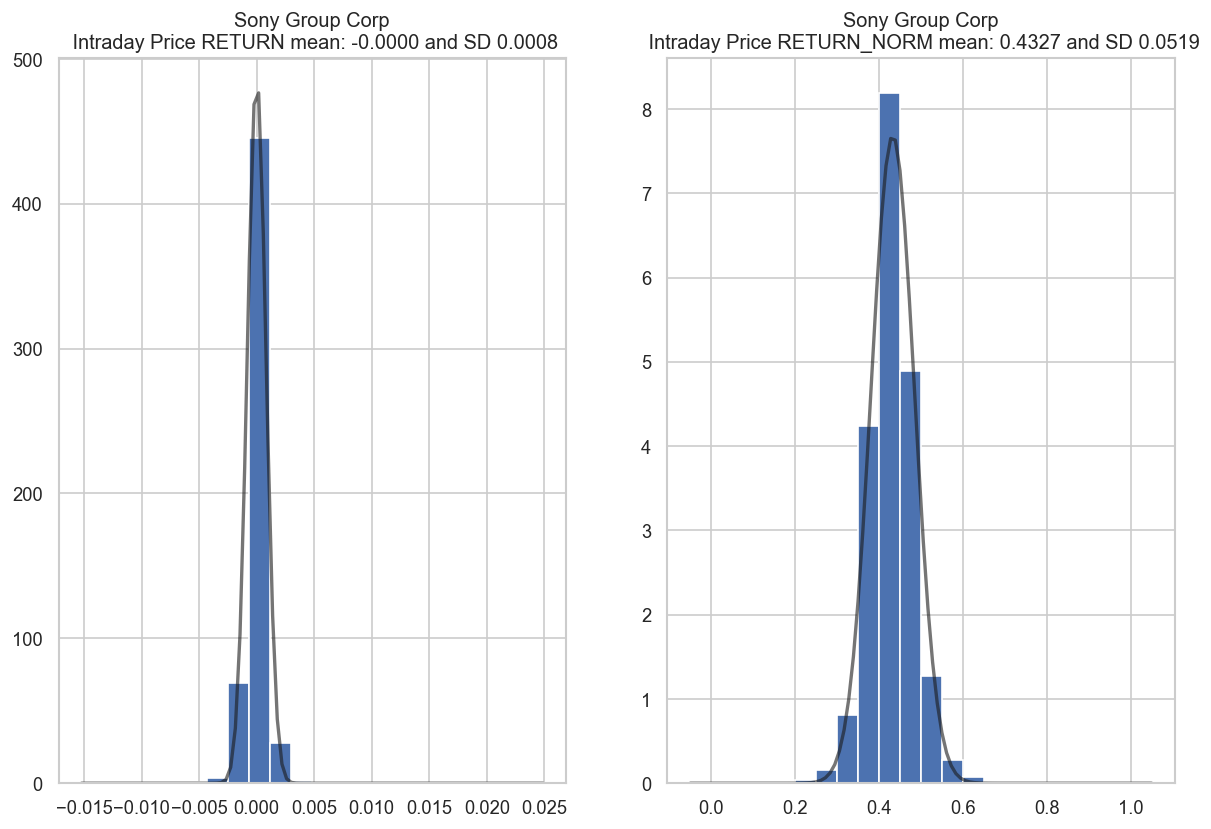

In [25]:
from scipy.stats import norm

def plot_fit(data, column):
	plt.subplot(1, 2, column)  # row 1, column 2, count 1
	plt.hist(data, bins=20, density=True, color='b')
	# Plot the PDF.
	mu, std = norm.fit(data) 
	xmin, xmax = plt.xlim()
	x = np.linspace(xmin, xmax, 100)
	p = norm.pdf(x, mu, std)
	
	plt.plot(x, p, 'k', alpha=0.6, linewidth=2)
	title = "{:s}\n Intraday Price {:s} mean: {:.4f} and SD {:.4f}".format(inst[2], data.name, mu, std)
	plt.title(title)
plot_fit(s.df_intraday['RETURN'],1)
plot_fit(s.df_intraday['RETURN_NORM'],2)

### Intraday volatility adjustment
#### Measures of Volatility
Mean of absolute return
$$\frac{1}{T}\sum^T_{t=1}\biggm\lvert\frac{C_t}{C_{t-1}} - 1\biggm\lvert$$
Garman and Klass (1980)
$$V_{ohlc} = 0.5[log(H) - log(L)]^2 - [2log(2) - 1)] [log(C) - log(O)]^2$$
The Garman-Klass estimator is a commonly used volatility measure and is  more effective than the basic formula since it takes into account not only the price at the beginning and end of the time interval but also intraminute price extremums. We use $σ_{ohlc} = \sqrt{V_{ohlc}}$ to be compatible with convention.
$\frac{1}{T}\sum^T_{t=1}σ_{ohlc}$. Two potential draw backs of the GK method are that it can be biased by opening jumps in price and trend movements, but neither is a significant concern as we are not including the opening day price and trend movements are minimal intraday.

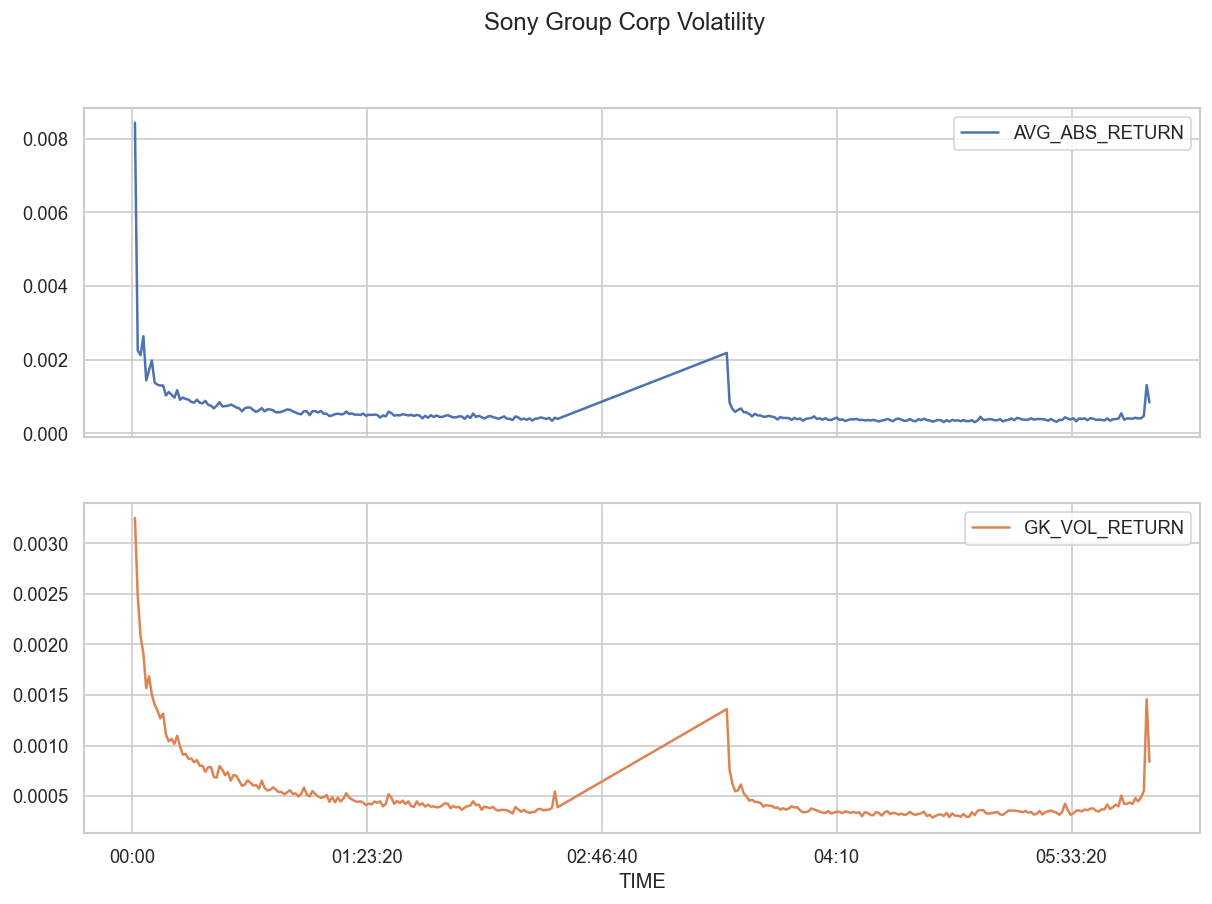

In [30]:
def plot_volatility(df):
	grouped = df.groupby("TIME").mean()
	title = "{:s} Volatility".format(inst[2])
	axes = grouped.plot.line(subplots=True, title=title)
plot_volatility(s.time_volatility.drop(columns='RETURN'))

#### Adjusting returns for time of intraday volatility
Assume trends are structurally nulls (i.e. $r_i=0$ for all i) and just divide each return by an empirical estimate of $σ_i$, replacing $dX_i/X_i$ by $d\tilde{X}_i=dX_i/(X_i σ_i)$.

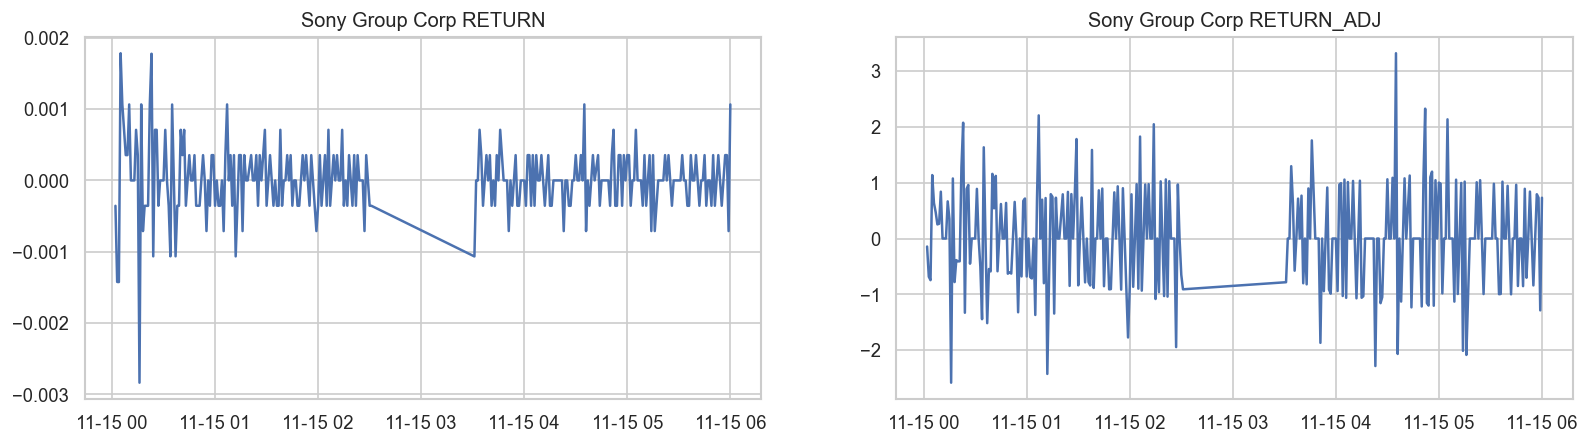

In [31]:
title = "{:s} Price".format(inst[2])
fig = plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1, title=f"{inst[2]} RETURN")  # row 1, column 1, count 1
plt.plot(data_1day ['Date'], data_1day['RETURN'])
plt.subplot(1, 2, 2, title=f"{inst[2]} RETURN_ADJ") # row 1, column 1, count 1
plt.plot(data_1day ['Date'], data_1day ['RETURN_ADJ'])


### Normalization
Normalization is scaling in which values are shifted and end up in a range between 0 and 1. We use Min-Max scaling for normalization.
$$N= \frac{AdjR - AdjR_{min}}{AdjR_{max} - AdjR_{min}}$$

## Processed Data
### Stock Price Data

In [33]:
%%capture --no-stdout
df_raw_data = s.df_intraday.drop(columns=['COUNT', 'VOLUME', 'CLOSE_TPX', 'RETURN_TPX', 'RETURN_ADJ_TPX', 'RETURN_NORM_TPX'])
print(df_raw_data.describe())
print("\r\nThe kurtosis of any univariate normal distribution is 3. Less than 3 indicates fewer and less extreme outliers while greater than 3 indicates more.")
print("RETURN has a much higher kurtosis than CLOSE because of the latter's autocorrelation causes it to have low kurtosis.")
print("RETURN_ADJ has a lower kurtosis than RETURN because it is adjusted for the intraday volatility patterns.")
print("RETURN_NORM has the same kurtosis as RETURN_ADJ because it is simply a scaled version of RETURN_ADJ.")
print("RETURN_ADJ, which we will be using for most of the Anomaly Detection methods, has a close to normal kurtosis, albeit a bit larger than normal.")
print(f"\r\nKurtosis:\r\n{df_raw_data.kurtosis().to_frame().T}\r\n")


               HIGH           LOW          OPEN         CLOSE        RETURN    RETURN_ADJ   RETURN_NORM
count  73105.000000  73105.000000  73105.000000  73105.000000  7.310500e+04  73105.000000  73105.000000
mean   11389.703057  11379.947199  11384.876602  11384.846974 -7.873748e-07      0.001696      0.432717
std     1064.566320   1063.859893   1064.205256   1064.195629  8.182736e-04      1.549051      0.051910
min     9405.000000   9388.000000   9399.000000   9398.000000 -1.338256e-02    -12.910940      0.000000
25%    10645.000000  10635.000000  10640.000000  10640.000000 -4.330879e-04     -1.027908      0.398214
50%    11250.000000  11240.000000  11245.000000  11245.000000  0.000000e+00      0.000000      0.432660
75%    11995.000000  11985.000000  11990.000000  11990.000000  4.327131e-04      1.021066      0.466877
max    14510.000000  14460.000000  14505.000000  14475.000000  2.303754e-02     16.929887      1.000000

The kurtosis of any univariate normal distribution is 3. Less t

### Including TSE 33 (TSI) Data
The Topix Sector Indices (TSI), also called TSE 33, data is stationarized, adjusted, and normlized in the same fashion.

In [38]:
# def plot_volatility(df):
# 	grouped = df.groupby("TIME").mean()
# 	title = "{:s} Volatility".format(inst[2])
# 	axes = grouped.plot.line(subplots=True, title=title)
# plot_volatility(s.time_volatility.drop(columns='RETURN'))
print(s.name)
print(s.time_volatility)
print(s.sector.name)
print(s.sector.time_volatility)

Sony Group Corp
         TIME    RETURN  AVG_ABS_RETURN  GK_VOL_RETURN
0    00:01:00  0.001371        0.008432       0.003251
1    00:02:00 -0.000480        0.002247       0.002476
2    00:03:00 -0.000308        0.002120       0.002078
3    00:04:00  0.000248        0.002636       0.001910
4    00:05:00  0.000149        0.001436       0.001569
..        ...       ...             ...            ...
297  05:57:00  0.000042        0.000401       0.000448
298  05:58:00 -0.000009        0.000409       0.000486
299  05:59:00 -0.000065        0.000468       0.000552
300  06:00:00  0.000195        0.001309       0.001458
301  06:01:00  0.000061        0.000839       0.000839

[302 rows x 4 columns]
Electric Appliances
         TIME    RETURN  AVG_ABS_RETURN  GK_VOL_RETURN
0    00:01:00  0.001202        0.006018       0.000342
1    00:02:00 -0.000003        0.001178       0.000523
2    00:03:00 -0.000181        0.000865       0.000436
3    00:04:00  0.000194        0.001386       0.000630
4    

In [36]:
%%capture --no-stdout
df_raw_data = s.df_intraday.drop(columns=['COUNT', 'VOLUME'])
print(df_raw_data.describe())
print("\r\nThe kurtosis of any univariate normal distribution is 3. Less than 3 indicates fewer and less extreme outliers while greater than 3 indicates more.")
print("RETURN_TPX has a much higher kurtosis than CLOSE_TPX because of the latter's autocorrelation causes it to have low kurtosis.")
print("RETURN_ADJ_TPX has a slightly lower kurtosis than RETURN_TPX because it is adjusted for the intraday volatility patterns.")
print("RETURN_NORM_TPX has the same kurtosis as RETURN_ADJ_TPX because it is simply a scaled version of RETURN_ADJ_TPX.")
print("RETURN_ADJ_TPX, which we will be using for contextual anomaly detection, has a larger than normal kurtosis indicating more than the normal number of exteme outliers.")
print(f"\r\nKurtosis:\r\n{df_raw_data.kurtosis().to_frame().T}\r\n")


               HIGH           LOW          OPEN         CLOSE        RETURN    RETURN_ADJ     CLOSE_TPX    RETURN_TPX  RETURN_ADJ_TPX   RETURN_NORM  RETURN_NORM_TPX
count  73105.000000  73105.000000  73105.000000  73105.000000  7.310500e+04  73105.000000  73105.000000  7.310500e+04    73105.000000  73105.000000     73105.000000
mean   11389.703057  11379.947199  11384.876602  11384.846974 -7.873748e-07      0.001696   3590.865595 -7.346634e-09        0.000717      0.432717         0.295132
std     1064.566320   1063.859893   1064.205256   1064.195629  8.182736e-04      1.549051    228.979283  4.520063e-04        3.045770      0.051910         0.024048
min     9405.000000   9388.000000   9399.000000   9398.000000 -1.338256e-02    -12.910940   3035.860000 -9.625975e-03      -37.379202      0.000000         0.000000
25%    10645.000000  10635.000000  10640.000000  10640.000000 -4.330879e-04     -1.027908   3481.900000 -1.953096e-04       -1.597426      0.398214         0.282514
50%    112

#### Stock/TSI Correlation

[Sony Group Corp/Nippon Suisan Kaisha Ltd]  Pearson's R: -0.005066048870893009   p-value: 0.24326891961214717
[Sony Group Corp/Electric Appliances]  Pearson's R: 0.49776087924543616   p-value: 0.0
[Nippon Suisan Kaisha Ltd/Fishery, Agriculture & Forestry]  Pearson's R: 0.6002399329849388   p-value: 0.0


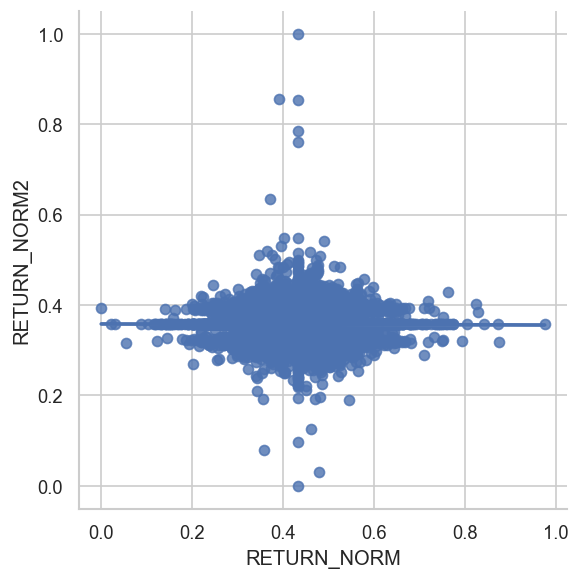

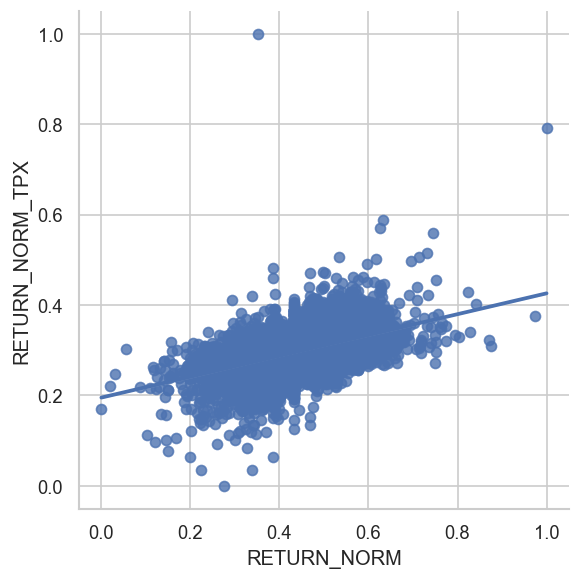

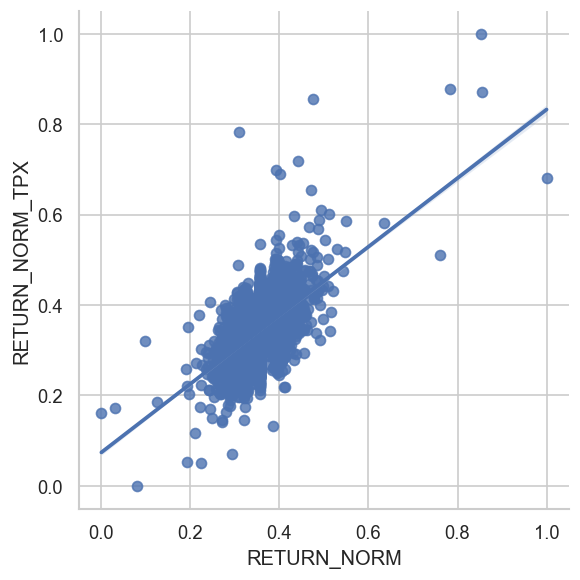

In [50]:

inst2 = NKY.get_ric("1332.T")
s2 = Stock(inst2, TSE33)

s1s2_df = pd. DataFrame(s.df_intraday[['Date','RETURN_NORM']])
s1s2_df['RETURN_NORM2'] = s2.df_intraday['RETURN_NORM']
s1s2_df = s1s2_df.dropna()
r,p = stats.pearsonr(s1s2_df['RETURN_NORM'], s1s2_df['RETURN_NORM2'])
print(f"[{s.name}/{s2.name}]  Pearson's R: {r}   p-value: {p}")
sns.lmplot(x='RETURN_NORM', y='RETURN_NORM2', data=s1s2_df)


r,p = stats.pearsonr(s.df_intraday['RETURN_NORM'], s.df_intraday['RETURN_NORM_TPX'])
print(f"[{s.name}/{s.sector.name}]  Pearson's R: {r}   p-value: {p}")
sns.lmplot(x='RETURN_NORM', y='RETURN_NORM_TPX', data=s.df_intraday)


r,p = stats.pearsonr(s2.df_intraday['RETURN_NORM'], s2.df_intraday['RETURN_NORM_TPX'])
print(f"[{s2.name}/{s2.sector.name}]  Pearson's R: {r}   p-value: {p}")
sns.lmplot(x='RETURN_NORM', y='RETURN_NORM_TPX', data=s2.df_intraday)
